In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load main RFM + Clustered data
rfm = pd.read_csv("rfm_clustered.csv")

# Load original invoice data (cleaned)
df = pd.read_csv("online_retail_cleaned.csv", parse_dates=['InvoiceDate'])

In [3]:
# --- Feature Engineering ---

# 1. Avg Order Value
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

# 2. Days Active: (last - first purchase) per customer
activity = df.groupby('CustomerID').agg({
    'InvoiceDate': ['min', 'max']
})
activity.columns = ['FirstPurchase', 'LastPurchase']
activity['DaysActive'] = (activity['LastPurchase'] - activity['FirstPurchase']).dt.days
activity.reset_index(inplace=True)  # Important for merging!

# Merge DaysActive into RFM
rfm = rfm.merge(activity[['CustomerID', 'DaysActive']], on='CustomerID', how='left')

# 3. Number of items purchased
quantity = df.groupby('CustomerID')['Quantity'].sum().reset_index()
rfm = rfm.merge(quantity, on='CustomerID', how='left')

In [4]:
# Store CustomerID if needed for later analysis
customer_ids = rfm['CustomerID']

# Define X and y
X = rfm.drop(columns=['CustomerID', 'Monetary'])  # Features
y = rfm['Monetary']                               # Target

In [5]:
# Train/Test Split

# Apply log1p to the target
y_log = np.log1p(y)

# Now split the log-transformed target
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

customer_ids_test = customer_ids.loc[X_test.index].reset_index(drop=True)

In [6]:
# xgboost
from xgboost import XGBRegressor

# Initialize and train the model
model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train_log)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [7]:
# Predict in log space
y_pred_log = model.predict(X_test)

# Clip to avoid overflow
y_pred_log = np.clip(y_pred_log, a_min=None, a_max=20)
y_test_log = np.clip(y_test_log, a_min=None, a_max=20)

# Reverse log1p
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

In [8]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 4036.17
R² Score: 0.84


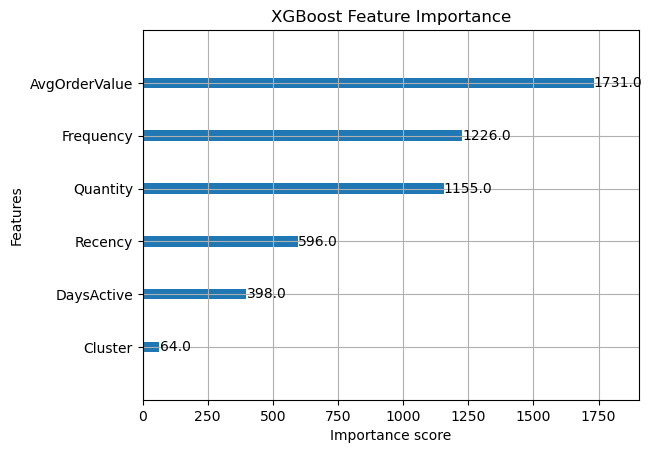

In [10]:
# Feature Importance
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

In [24]:
results = pd.DataFrame({
    'CustomerID': customer_ids_test,
    'Actual_CLV': y_test.reset_index(drop=True),
    'Predicted_CLV': pd.Series(y_pred).reset_index(drop=True)
})
results.head(10)

,CustomerID,Actual_CLV,Predicted_CLV
0,17785.0,131.94,134.289352
1,14320.0,477.79,472.455078
2,15977.0,1054.73,1172.245605
3,12364.0,1313.10,1423.297607
4,14566.0,1432.00,1389.820923
5,13521.0,1071.73,1098.695923
6,12515.0,383.70,390.690063
7,15528.0,229.33,231.199966
8,15071.0,982.07,973.648804
9,16275.0,559.87,548.223816


In [28]:
import joblib
joblib.dump(model, "xgb_clv_model.pkl")

['xgb_clv_model.pkl']